In [1]:
from AL import *
from passive_model_perf import *
from update_combined_data import *
#from eval_adaptability import *
from compare_ATL_strategies import *
from analyze_target_tree_growth import *

import numpy as np
import pandas as pd
import joblib
import copy
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_dunn
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
source_id = joblib.load("./array_joblibs/final_source_id_dict.joblib")
source_desc = joblib.load("./array_joblibs/final_source_desc_dict.joblib")
source_y = joblib.load("./array_joblibs/final_source_y_dict.joblib")
target_id = joblib.load("./array_joblibs/final_target_id_dict.joblib")
target_desc = joblib.load("./array_joblibs/final_target_desc_dict.joblib")
target_y = joblib.load("./array_joblibs/final_target_y_dict.joblib")

In [3]:
DOMAINS = ["amides", "sulfonamides", "ROH", "anilines", "heterocycles", "alkyl amines"]
num_desired_rxns = [len(target_y[x])-sum(target_y[x]) for x in DOMAINS]
print(num_desired_rxns)

[5.0, 14.0, 17.0, 2.0, 8.0, 3.0]


In [4]:
[len(target_y[x]) for x in DOMAINS]

[40, 40, 48, 43, 43, 43]

In [5]:
### Preparing 100 source models of 5 trees of depth 1
hund_source_models = []
for i, source in enumerate(DOMAINS):
    model_list = prepare_models(source_desc[source], source_y[source], 100)
    hund_source_models.append(model_list)

In [12]:
def trellis_of_ATL_perfs(
    sources, targets, all_source_models,
    strategies=["Passive", "Combined Data", "Add 3 Trees", "No Source"],
    filename=None
):
    """ Prepares a 3x3 trellis plot of ATL performances compared to other baselines."""
    fig, ax = plt.subplots(3, 3, figsize=(12,10), gridspec_kw={"wspace":0.1, "hspace":0.1})
    all_perfs = {}
    for j, target in enumerate(targets):
        for i, source in enumerate(sources):
            if source != target : 
                ATL_perf, models = compare_ATL_strategies(
                    [source], [all_source_models[i]], [source_desc[source]], [source_y[source]],
                    target_desc[target], target_id[target], target_y[target], strategies=strategies
                )
                all_perfs.update({(i,j):list(ATL_perf.values())[0]})
                if "Passive" not in strategies : # for consistent color and style schemes
                    dict_to_plot = list(ATL_perf.values())[0]
                    dict_to_plot["num_rxns_conducted"].insert(0, 0)
                    dict_to_plot["num_rxns_found"].insert(0, 0)
                    dict_to_plot["Strategy"].insert(0, "Passive")
                
                scenario = f"{source}_to_{target}"
                sns.lineplot(
                    x="num_rxns_conducted", y="num_rxns_found",
                    hue="Strategy", style="Strategy", markers=True,
                    ci=95, palette="plasma", data=list(ATL_perf.values())[0], ax=ax[j,i]
                )
                if j < 2 :
                    ax[j,i].set_xticklabels([])
                    ax[j,i].set_xlabel('')
                    if i == 2 and j == 0 :
                        handles, labels = ax[j,i].get_legend_handles_labels()
                        ax[j,i].legend(handles[1:], labels[1:], title="Strategy")
                    else :
                        ax[j,i].get_legend().remove()
                else :
                    if i == 1 :
                        ax[j,i].set_xlabel(r"$\bf{"+'Number\ of\ Reactions\ Conducted'+"}$"+ f"\n\n{source}\n\n" +  r"$\bf{"+ 'Source\ Nucleophile'+ "}$",
                                           fontsize=12)
                        ax[j,i].get_legend().remove()
                    else : 
                        ax[j,i].set_xlabel("\n\n"+source, fontsize=12)
                        ax[j,i].get_legend().remove()
                            
                
                yticks = np.arange(len(target_y[target])-sum(target_y[target])+1, dtype=np.int8)
                ax[j,i].set_yticks(yticks)
                if i > 0 : 
                    ax[j,i].set_ylabel('')
                    ax[j,i].set_yticklabels([])
                    
                else :
                    if j!= 1:
                        ax[j,i].set_ylabel(target+"\n\n", fontsize=12)
                    else :
                        ax[j,i].set_ylabel(r"$\bf{"+"Target\ Nucleophile"+"}$" + f"\n\n{target}\n\n" + r"$\bf{"+ "Number\ of\ Reactions\ Found" + "}$",
                                          fontsize=12)

                    ax[j,i].set_yticklabels(yticks)
                for axis in ['top', 'bottom', 'left', 'right']:
                    ax[j,i].spines[axis].set_linewidth(2)
                if sources == targets :
                    if j == 0 and i==1 :
                        ax[j,i].set_yticklabels(yticks)
                    elif j == 1 and i==2 :
                        xticks = list(ax[j,i].get_xticks())
                        xticks = [int(x) for x in xticks]
                        ax[j,i].set_xticklabels(xticks)
            
            else :
                if i == 0 :
                    ax[j,i].set_ylabel(target+"\n\n\n", fontsize=12)
                    # make x axis invisible
                    ax[j,i].xaxis.set_visible(False)
                    # makes the box invisible
                    plt.setp(ax[j,i].spines.values(), visible=False)
                    # remove ticks and labels for left axis
                    ax[j,i].tick_params(left=False, labelleft=False)
                
                if i == 1 :
                    ax[j,i].xaxis.set_visible(False)
                    ax[j,i].yaxis.set_visible(False)
                    plt.setp(ax[j,i].spines.values(), visible=False)
                    ax[j,i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
                elif i == 2 :
                    ax[j,i].set_xlabel("\n\n\n"+source, fontsize=12)
                    ax[j,i].yaxis.set_visible(False)
                    plt.setp(ax[j,i].spines.values(), visible=False)
                    # remove ticks and labels for bottom axis
                    ax[j,i].tick_params(bottom=False, labelbottom=False)
    if filename is not None:
        fig.savefig(f"./figures/{filename}.pdf",
                    dpi=300, format="pdf", bbox_inches="tight")
    return all_perfs

100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


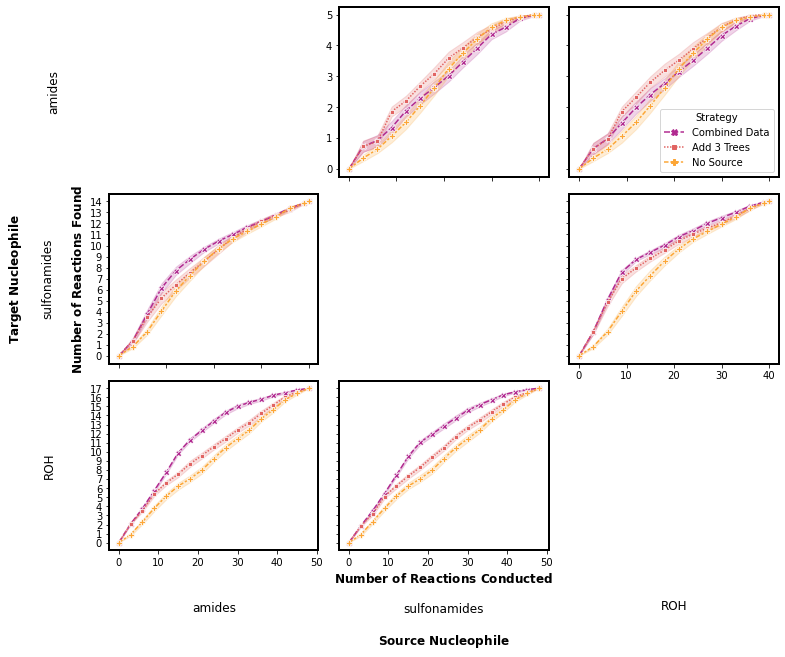

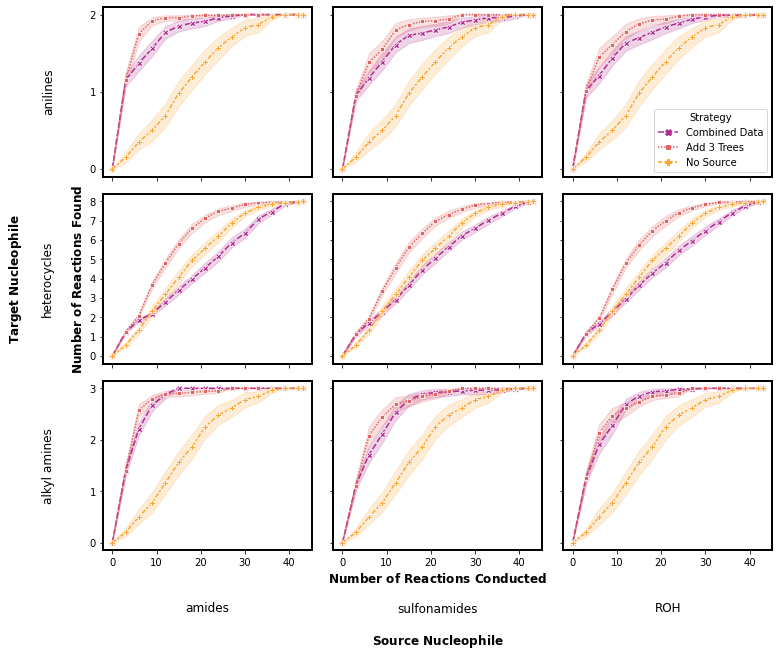

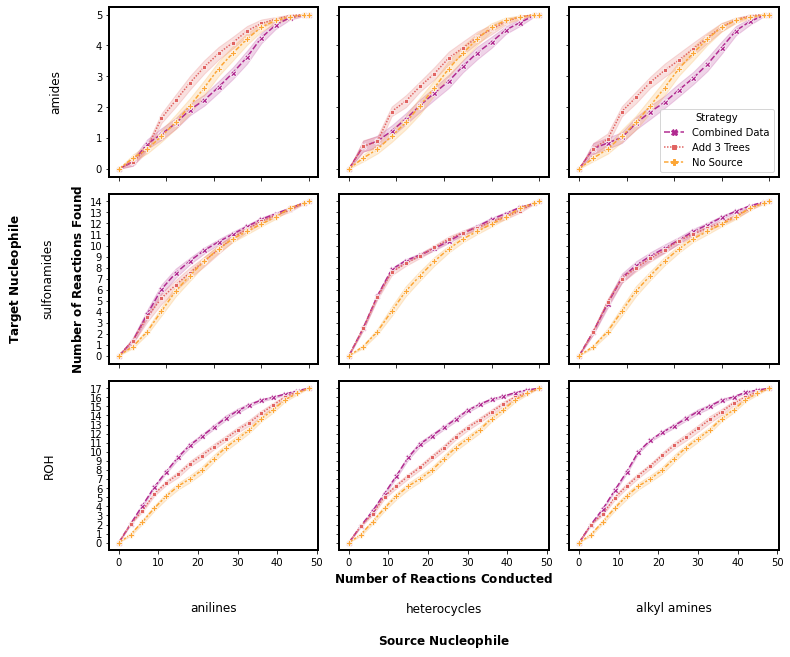

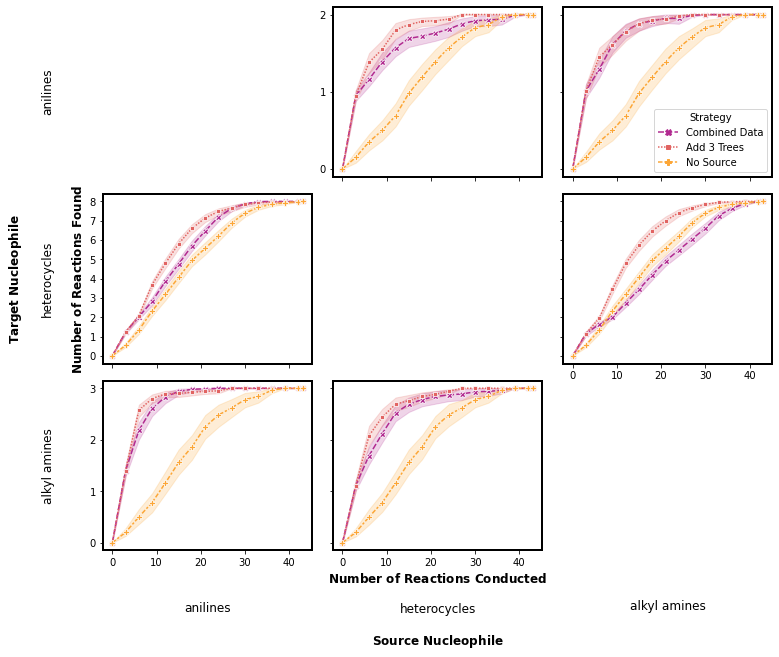

In [13]:
first_x_first_perfs_hund = trellis_of_ATL_perfs(DOMAINS[:3], DOMAINS[:3], hund_source_models, strategies=["Combined Data", "Add 3 Trees", "No Source"], filename="FigureS17A")
first_x_sec_perfs_hund = trellis_of_ATL_perfs(DOMAINS[:3], DOMAINS[3:], hund_source_models, strategies=["Combined Data", "Add 3 Trees", "No Source"], filename="FigureS17B")
sec_x_first_perfs_hund = trellis_of_ATL_perfs(DOMAINS[3:], DOMAINS[:3], hund_source_models, strategies=["Combined Data", "Add 3 Trees", "No Source"], filename="FigureS17C")
sec_x_sec_perfs_hund = trellis_of_ATL_perfs(DOMAINS[3:], DOMAINS[3:], hund_source_models, strategies=["Combined Data", "Add 3 Trees", "No Source"], filename="FigureS17D")

In [14]:
iter_scores = np.zeros((3, 6, 30))

below_ten_count = 0
over_ten_count = 20
for perf_dict in [first_x_first_perfs_hund, first_x_sec_perfs_hund, sec_x_first_perfs_hund, sec_x_sec_perfs_hund] :
    for k, v in perf_dict.items():
        df = pd.DataFrame.from_dict(v)
        num_rxns_to_be_found = max(df["num_rxns_found"])
        if num_rxns_to_be_found < 10 :
            count = below_ten_count
        else : 
            count = over_ten_count
        for i, strategy in enumerate(["Combined Data", "Add 3 Trees", "No Source"]):
            for j in range(6):
                iter_scores[i, j, count] = df[df["num_rxns_conducted"]==3*(j+1)][df["Strategy"]==strategy]["num_rxns_found"].mean()/min([3*(j+1),num_rxns_to_be_found]) 
          
        if num_rxns_to_be_found < 10 :
            below_ten_count += 1
        else : 
            over_ten_count += 1

/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame ind

/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame ind

/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame ind

/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame ind

/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/eunjae/anaconda3/envs/transfer/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame ind

In [15]:
# Friedman Test
for j in range(6) : 
    _, p = friedmanchisquare(iter_scores[0,j,:], iter_scores[1,j,:], iter_scores[2,j,:])
    print(p)

4.471338401976114e-12
1.4807039204169627e-10
2.7657708911208426e-08
1.6788275299956724e-07
3.2717419245495627e-07
8.29381916075746e-06


In [17]:
# Holm-Dunn post-hoc test on transfer where target has >30% positives
for j in range(6):
    p_bd = posthoc_dunn(iter_scores[:,j,20:], p_adjust="holm")
    print(p_bd)
    print()
    print()

          1         2         3
1  1.000000  1.000000  0.000361
2  1.000000  1.000000  0.000361
3  0.000361  0.000361  1.000000


          1         2         3
1  1.000000  0.357981  0.000054
2  0.357981  1.000000  0.001501
3  0.000054  0.001501  1.000000


          1         2         3
1  1.000000  0.152839  0.000017
2  0.152839  1.000000  0.003686
3  0.000017  0.003686  1.000000


          1         2         3
1  1.000000  0.152885  0.000017
2  0.152885  1.000000  0.003690
3  0.000017  0.003690  1.000000


          1         2         3
1  1.000000  0.026576  0.000119
2  0.026576  1.000000  0.102339
3  0.000119  0.102339  1.000000


          1         2         3
1  1.000000  0.035207  0.000712
2  0.035207  1.000000  0.192989
3  0.000712  0.192989  1.000000




In [18]:
# Holm-Dunn post-hoc test on challenging transfer scenarios
for j in range(6):
    p_bd = posthoc_dunn(iter_scores[:,j,:20], p_adjust="holm")
    print(p_bd)
    print()
    print()

              1             2             3
1  1.000000e+00  1.000000e+00  6.871504e-07
2  1.000000e+00  1.000000e+00  6.871504e-07
3  6.871504e-07  6.871504e-07  1.000000e+00


          1         2         3
1  1.000000  0.389159  0.000133
2  0.389159  1.000000  0.000004
3  0.000133  0.000004  1.000000


          1             2             3
1  1.000000  2.956175e-02  2.198033e-03
2  0.029562  1.000000e+00  1.600365e-07
3  0.002198  1.600365e-07  1.000000e+00


          1             2             3
1  1.000000  2.028999e-02  1.076125e-02
2  0.020290  1.000000e+00  9.962814e-07
3  0.010761  9.962814e-07  1.000000e+00


         1         2         3
1  1.00000  0.038690  0.038690
2  0.03869  1.000000  0.000011
3  0.03869  0.000011  1.000000


          1         2         3
1  1.000000  0.035091  0.052386
2  0.035091  1.000000  0.000048
3  0.052386  0.000048  1.000000




In [19]:
iter_scores.shape
percent_improvement_dict_harder = {
    "Comparison":[],
    "Improvement":[],
    "Iteration":[]
}
percent_improvement_dict_easier = {
    "Comparison":[],
    "Improvement":[],
    "Iteration":[]
}
for j in range(6):
    atl_vs_comb = (np.divide(iter_scores[1,j,:20], iter_scores[0,j,:20]) - 1) * 100
    atl_vs_al = (np.divide(iter_scores[1,j,:20], iter_scores[2,j,:20]) - 1) * 100
    percent_improvement_dict_harder["Iteration"] += [j+1]*40
    percent_improvement_dict_harder["Comparison"] += ["Add Trees vs Combine Data"] * 20
    percent_improvement_dict_harder["Comparison"] += ["Add Trees vs No Transfer"] * 20
    percent_improvement_dict_harder["Improvement"] += list(atl_vs_comb)
    percent_improvement_dict_harder["Improvement"] += list(atl_vs_al)
    
    atl_vs_comb_ez = (np.divide(iter_scores[1,j,20:], iter_scores[0,j,20:]) - 1) * 100
    atl_vs_al_ez = (np.divide(iter_scores[1,j,20:], iter_scores[2,j,20:]) - 1) * 100
    percent_improvement_dict_easier["Iteration"] += [j+1]*20
    percent_improvement_dict_easier["Comparison"] += ["Add Trees vs Combine Data"] * 10
    percent_improvement_dict_easier["Comparison"] += ["Add Trees vs No Transfer"] * 10
    percent_improvement_dict_easier["Improvement"] += list(atl_vs_comb_ez)
    percent_improvement_dict_easier["Improvement"] += list(atl_vs_al_ez)

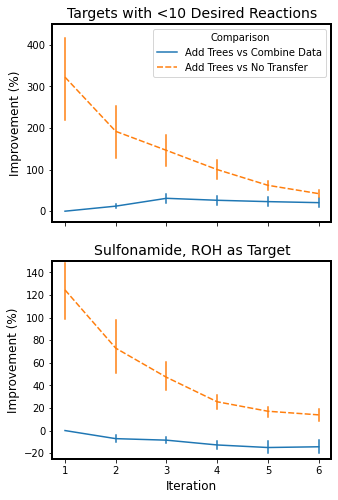

In [21]:
fig, ax = plt.subplots(2,1, figsize=(5,8), sharex=True)
sns.lineplot(x="Iteration", y="Improvement", hue="Comparison", style="Comparison", data=percent_improvement_dict_harder,
            err_style="bars", ax=ax[0])
ax[0].set_ylim([-25, 450])
ax[0].set_ylabel("Improvement (%)", fontsize=12)
ax[0].set_title("Targets with <10 Desired Reactions", fontsize=14)
sns.lineplot(x="Iteration", y="Improvement", hue="Comparison", style="Comparison", data=percent_improvement_dict_easier,
            err_style="bars", ax=ax[1])
ax[1].set_title("Sulfonamide, ROH as Target", fontsize=14)
ax[1].set_ylim([-25, 150])
ax[1].get_legend().remove()
ax[1].set_ylabel("Improvement (%)", fontsize=12)
ax[1].set_xlabel("Iteration", fontsize=12)
for axs in ax :
    for axis in ['top', 'bottom', 'left', 'right']:
        axs.spines[axis].set_linewidth(2)
fig.savefig(f"./figures/FigureS18.pdf",
                    dpi=300, format="pdf", bbox_inches="tight") 

In [28]:
joblib.dump(
    [first_x_first_perfs, first_x_sec_perfs, sec_x_first_perfs, sec_x_sec_perfs],
    "./array_joblibs/atl_perfs.joblib"
)

['./array_joblibs/atl_perfs.joblib']